In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from sklearn import svm
import re
from nltk.stem.porter import PorterStemmer

with open("emailSample1.txt", "r") as readfile:
    email_contents_s1 = readfile.read()
with open("vocab.txt", "r") as readfile:
    vocab_dict = {}
    for line in readfile:
        line = line.split()
        vocab_dict[line[1]] = line[0]

print(email_contents_s1)
print(vocab_dict)

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com


{'aa': '1', 'ab': '2', 'abil': '3', 'abl': '4', 'about': '5', 'abov': '6', 'absolut': '7', 'abus': '8', 'ac': '9', 'accept': '10', 'access': '11', 'accord': '12', 'account': '13', 'achiev': '14', 'acquir': '15', 'across': '16', 'act': '17', 'action': '18', 'activ': '19', 'actual': '20', 'ad': '21', 'adam': '22', 'add': '23', 'addit': '24', 'address': '25', 'administr': '26', 'adult': '27', 'advanc': '28', 'advantag': '29', 'advertis': '30', 'advic': '31', 'advis': '32', 'ae': '33', 'af': '34', 'affect': '35', 'affili': '36', 'afford': '37', 'africa': '38', 'after': '39', 'ag': '40', 'again': '41', '

In [2]:
def preprocessEmail(email_contents):
    # make lowercase
    email_contents = email_contents.lower()
    
    # strip HTML
    email_contents = re.sub('<[^<>]+>', ' ', email_contents)
    
    # handle numbers
    email_contents = re.sub("[0-9]+", 'number', email_contents)
    
    # handle URLs
    email_contents = re.sub("(http|https)://[^\s]*", "httpaddr", email_contents)
    
    # handle email addresses
    email_contents = re.sub('[^\s]+@[^\s]+', 'emailaddr', email_contents)
    
    # handle $ sign
    email_contents = re.sub("[$]+", "dollar", email_contents)
    
    return email_contents

def makeWordIndicies(email_contents):
    '''
    Tokenizes by whitespace and punctuation.
    Stems word and checks if stem is in vocab_dict
    '''
    stemmer = PorterStemmer()
    global vocab_dict
    word_indices = []
    
    # tokenize and get rid of punctuation
    tokens = re.split("""[\s@$/#.-:&*+=[\]?!(){},'">_<;%]""", email_contents)
    for token in tokens:
        # remove non alphanumberic characters
        token = re.sub("[^a-zA-Z0-9]", '', token)
        stem = stemmer.stem(token)
        if len(stem) < 1:
            continue
        if stem in vocab_dict:
            word_indices.append(vocab_dict[stem])
    return word_indices

def processEmail(file_contents):
    email_contents = preprocessEmail(file_contents)
    return makeWordIndicies(email_contents)

word_indices = processEmail(email_contents_s1)
print(word_indices)

['86', '916', '794', '1077', '883', '370', '1699', '790', '1822', '1831', '883', '431', '1171', '794', '1002', '1893', '1364', '592', '1676', '238', '162', '89', '688', '945', '1663', '1120', '1062', '1699', '375', '1162', '479', '1893', '1510', '799', '1182', '1237', '810', '1895', '1440', '1547', '181', '1699', '1758', '1896', '688', '1676', '992', '961', '1477', '71', '530', '1699', '531']


In [3]:
# converting to feature vector

dict_n = len(vocab_dict.keys())
print("number of keys in vocab_dict: ", dict_n)

def emailFeatures(word_indices):
    global dict_n
    global vocab_dict
    
    featureVec = np.zeros(dict_n)
    for i in word_indices:
        i = int(i)
        featureVec[i] = 1
    return featureVec

featureVec = emailFeatures(word_indices)
print("feature vector: ", featureVec)
print("number of non-zero entries: ", sum(featureVec))

number of keys in vocab_dict:  1899
feature vector:  [ 0.  0.  0. ...,  1.  0.  0.]
number of non-zero entries:  45.0


In [39]:
spamTrain = scipy.io.loadmat("spamTrain.mat")
spamTest = scipy.io.loadmat("spamTest.mat")

X_train = spamTrain["X"]
y_train = spamTrain["y"].ravel()

X_test = spamTest["Xtest"]
y_test = spamTest["ytest"].ravel()

# train linear SVM classifier

C = 0.1
clf = svm.SVC(C=C, kernel="linear")
clf.fit(X_train, y_train)

def svmPredict(model, X):
    # returns predictions
    predictions = clf.predict(X)
    return predictions.ravel()

def getAccuracy(predictions, y):
    logicalVec = predictions == y
    logicalVec = logicalVec.astype(int)
    return sum(logicalVec) / len(logicalVec)

predictions_train = svmPredict(clf, X_train)
print(getAccuracy(predictions_train, y_train))

predictions_test = svmPredict(clf, X_test)
print(getAccuracy(predictions_test, y_test))

0.99825
0.989


In [40]:
highestInd = np.argsort(-clf.coef_)[0]
# argsort can't sort by desc, so negate clf.coef_ for to get sorted by desc

print(highestInd,"\n")

# switch key, values for vocab_dict (key-values will be int: str)
vocab_dict_switch = {y:x for x,y in vocab_dict.items()}

print('Top 15 predictor words for spam:')
for i in range(15):
    index = highestInd[i]
    word = vocab_dict_switch[str(index)]
    print("- " + word)

[1190  297 1397 ..., 1764 1665 1560] 

Top 15 predictor words for spam:
- otherwis
- clearli
- remot
- gt
- visa
- base
- doesn
- wife
- previous
- player
- mortgag
- natur
- ll
- futur
- hot


In [42]:
def detectIfSpam(email_content, clf):
    wordIndices = processEmail(email_content)
    featureVec = emailFeatures(wordIndices).reshape(1,-1) # single email, reshape to 2D array
    prediction = svmPredict(clf, featureVec)    
    return prediction

def exampleEmailTest(clf):
    emails = ["emailSample1.txt", "spamSample1.txt", "emailSample2.txt", "spamSample2.txt"]

    for email in emails:
        with open(email, "r") as readfile:
            content = readfile.read()
        result = detectIfSpam(content, clf)
        if result == 1:
            print(email, " is predicted to be spam.")
        else:
            print(email, " is predicted to not be spam.")
    return

exampleEmailTest(clf)

emailSample1.txt  is predicted to not be spam.
spamSample1.txt  is predicted to not be spam.
emailSample2.txt  is predicted to not be spam.
spamSample2.txt  is predicted to be spam.


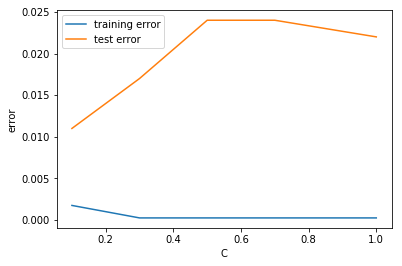

In [48]:
# seems like spamSample1 is not predicted correctly. Let's see if we can adjust
# C value to see if we get better performance. We will use a learning curve

C_vec = [0.1,0.3,0.5,0.7,1]
error_train_vec = []
error_test_vec = []

for C in C_vec:
    clf = svm.SVC(C=C, kernel="linear")
    clf.fit(X_train, y_train)

    predictions_train = svmPredict(clf, X_train)
    accuracy_train = getAccuracy(predictions_train, y_train)
    error_train = 1-accuracy_train
    error_train_vec.append(error_train)

    predictions_test = svmPredict(clf, X_test)
    accuracy_test = getAccuracy(predictions_test, y_test)
    error_test = 1-accuracy_test
    error_test_vec.append(error_test)

plt.plot(C_vec, error_train_vec, label="training error")
plt.plot(C_vec, error_test_vec, label="test error")
plt.xlabel("C")
plt.ylabel("error")
plt.legend()
plt.show()

In [47]:
C = 0.3
clf = svm.SVC(C=C, kernel="linear")
clf.fit(X_train, y_train)
exampleEmailTest(clf)

emailSample1.txt  is predicted to not be spam.
spamSample1.txt  is predicted to be spam.
emailSample2.txt  is predicted to not be spam.
spamSample2.txt  is predicted to be spam.


In [19]:
C = 0.03
clf = svm.SVC(C=C, kernel="linear")
clf.fit(X_train, y_train)

def svmPredict(model, X):
    # returns predictions
    predictions = clf.predict(X)
    return predictions.ravel()

def getAccuracy(predictions, y):
    logicalVec = predictions == y
    logicalVec = logicalVec.astype(int)
    return sum(logicalVec) / len(logicalVec)

predictions_train = svmPredict(clf, X_train)
print(getAccuracy(predictions_train, y_train))

predictions_test = svmPredict(clf, X_test)
print(getAccuracy(predictions_test, y_test))

0.99425
0.99


In [30]:
def testC(C_vec, X_train, y_train, X_test, y_test):
    error_train = []
    clf = svm.SVC(C=0.1, kernel="linear")
    clf.fit(X_train, y_train)
    pred = svmPredict(clf, X_train)
    acc = getAccuracy(pred, y_train)
    error_train.append(acc)
    
    clf = svm.SVC(C=100, kernel="linear")
    clf.fit(X_train, y_train)
    pred = svmPredict(clf, X_train)
    acc = getAccuracy(pred, y_train)
    error_train.append(acc)
    return error_train

print(testC(C_vec, X_train, y_train, X_test, y_test))

[1.0, 1.0]


In [31]:
error_train = []
clf = svm.SVC(C=0.1, kernel="linear")
clf.fit(X_train, y_train)
pred = svmPredict(clf, X_train)
acc = getAccuracy(pred, y_train)
error_train.append(acc)

clf = svm.SVC(C=100, kernel="linear")
clf.fit(X_train, y_train)
pred = svmPredict(clf, X_train)
acc = getAccuracy(pred, y_train)
error_train.append(acc)
print(error_train)

[0.99824999999999997, 1.0]
